In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from numpy import array
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd     

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [4]:
LABELS = np.array(['aircraft carrier','airplane','alarm clock','ambulance','angel',
                   'animal migration','ant','anvil','apple','arm','asparagus','axe',
                   'backpack','banana','bandage','barn','baseball','baseball bat',
                   'basket','basketball','bat','bathtub','beach','bear','beard','bed',
                   'bee','belt','bench','bicycle','binoculars','bird','birthday cake',
                   'blackberry','blueberry','book','boomerang','bottlecap','bowtie','bracelet',
                   'brain','bread','bridge','broccoli','broom','bucket','bulldozer','bus','bush',
                   'butterfly','cactus','cake','calculator','calendar','camel','camera','camouflage','campfire','candle','cannon','canoe','car','carrot','castle','cat','ceiling fan','cello','cell phone','chair',
                   'chandelier','church','circle','clarinet','clock','cloud','coffee cup','compass','computer','cookie','cooler','couch','cow','crab','crayon','crocodile','crown','cruise ship','cup','diamond',
                   'dishwasher','diving board','dog','dolphin','donut','door','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow','elephant','envelope','eraser','eye','eyeglasses','face','fan',
                   'feather','fence','finger','fire hydrant','fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer','foot','fork','frog','frying pan','garden',
                   'garden hose','giraffe','goatee','golf club','grapes','grass','guitar','hamburger','hammer','hand','harp','hat','headphones','hedgehog','helicopter','helmet','hexagon','hockey puck','hockey stick',
                   'horse','hospital','hot air balloon','hot dog','hot tub','hourglass','house','house plant','hurricane','ice cream','jacket','jail','kangaroo','key','keyboard','knee','knife','ladder','lantern','laptop',
                   'leaf','leg','light bulb','lighter','lighthouse','lightning','line','lion','lipstick','lobster','lollipop','mailbox','map','marker','matches','megaphone','mermaid','microphone','microwave','monkey',
                   'moon','mosquito','motorbike','mountain','mouse','moustache','mouth','mug','mushroom','nail','necklace','nose','ocean','octagon','octopus','onion','oven','owl','paintbrush','paint can','palm tree',
                   'panda','pants','paper clip','parachute','parrot','passport','peanut','pear','peas','pencil','penguin','piano','pickup truck','picture frame','pig','pillow','pineapple','pizza','pliers','police car',
                   'pond','pool','popsicle','postcard','potato','power outlet','purse','rabbit','raccoon','radio','rain','rainbow','rake','remote control','rhinoceros','rifle','river','roller coaster','rollerskates',
                   'sailboat','sandwich','saw','saxophone','school bus','scissors','scorpion','screwdriver','sea turtle','see saw','shark','sheep','shoe','shorts','shovel','sink','skateboard','skull','skyscraper',
                   'sleeping bag','smiley face','snail','snake','snorkel','snowflake','snowman','soccer ball','sock','speedboat','spider','spoon','spreadsheet','square','squiggle','squirrel','stairs','star','steak',
                   'stereo','stethoscope','stitches','stop sign','stove','strawberry','streetlight','string bean','submarine','suitcase','sun','swan','sweater','swing set','sword','syringe','table','teapot','teddy-bear',
                   'telephone','television','tennis racquet','tent','The Eiffel Tower','The Great Wall of China','The Mona Lisa','tiger','toaster','toe','toilet','tooth','toothbrush','toothpaste','tornado','tractor',
                   'traffic light','train','tree','triangle','trombone','truck','trumpet','t-shirt','umbrella','underwear','van','vase','violin','washing machine','watermelon','waterslide','whale','wheel','windmill',
                   'wine bottle','wine glass','wristwatch','yoga','zebra','zigzag'])
# LABELS = np.array(['blackberry','blueberry','book','boomerang','bottlecap','bowtie','bracelet',
#                    'brain','bread','bridge','broccoli','broom','bucket','bulldozer','bus','bush',
#                    'butterfly','cactus','cake','calculator','calendar','camel','camera','camouflage','campfire','candle','cannon','canoe','car','carrot','castle','cat','ceiling fan','cello','cell phone','chair',
#                    'chandelier','church','circle','clarinet','clock','cloud','coffee cup','compass','computer','cookie','cooler','couch','cow','crab','crayon','crocodile','crown','cruise ship','cup','diamond',
#                    'dishwasher','diving board','dog','dolphin','donut','door','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow','elephant','envelope','eraser','eye','eyeglasses','face','fan',
#                    'feather','fence','finger','fire hydrant','fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer','foot','fork','frog','frying pan','garden',
#                    'garden hose','giraffe','goatee','golf club','grapes','grass','guitar','hamburger','hammer','hand','harp','hat','headphones','hedgehog','helicopter','helmet','hexagon','hockey puck','hockey stick',
#                    'horse','hospital','hot air balloon','hot dog','hot tub','hourglass','house','house plant','hurricane','ice cream','jacket','jail','kangaroo','key','keyboard','knee','knife','ladder','lantern','laptop',
#                    'leaf','leg','light bulb','lighter','lighthouse','lightning','line','lion','lipstick','lobster','lollipop','mailbox','map','marker','matches','megaphone','mermaid','microphone','microwave','monkey',
#                    'moon','mosquito','motorbike','mountain','mouse','moustache','mouth','mug','mushroom','nail','necklace','nose','ocean','octagon','octopus','onion','oven','owl','paintbrush','paint can','palm tree',
#                    'panda','pants','paper clip','parachute','parrot','passport','peanut','pear','peas','pencil','penguin','piano','pickup truck','picture frame','pig','pillow','pineapple','pizza','pliers','police car',
#                    'pond','pool','popsicle','postcard','potato','power outlet','purse','rabbit','raccoon','radio','rain','rainbow','rake','remote control','rhinoceros','rifle','river','roller coaster','rollerskates',
#                    'sailboat','sandwich','saw','saxophone','school bus','scissors','scorpion','screwdriver','sea turtle','see saw','shark','sheep','shoe','shorts','shovel','sink','skateboard','skull','skyscraper',
#                    'sleeping bag','smiley face','snail','snake','snorkel','snowflake','snowman','soccer ball','sock','speedboat','spider','spoon','spreadsheet','square','squiggle','squirrel','stairs','star','steak',
#                    'stereo','stethoscope','stitches','stop sign','stove','strawberry','streetlight','string bean','submarine','suitcase','sun','swan','sweater','swing set','sword','syringe','table','teapot','teddy-bear',
#                    'telephone','television','tennis racquet','tent','The Eiffel Tower','The Great Wall of China','The Mona Lisa','tiger','toaster','toe','toilet','tooth','toothbrush','toothpaste','tornado','tractor',
#                    'traffic light','train','tree','triangle','trombone','truck','trumpet','t-shirt','umbrella','underwear','van','vase','violin','washing machine','watermelon','waterslide','whale','wheel','windmill',
#                    'wine bottle','wine glass','wristwatch','yoga','zebra','zigzag'])

In [5]:
# for b in LABELS:
#     !wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{b}.npy'

In [6]:
N_FRUITS = len(LABELS)
FRUITS = {}
files=[]
for i in range(0,N_FRUITS):
  FRUITS.update({i:LABELS[i]})
  files.append(LABELS[i]+".npy")
#FRUITS = {0: "Apple", 1: "Banana", 2: "Grape", 3: "Pineapple"}

# number of samples to take in each class
N = 5000

# some other constants
N_EPOCHS = 5
print(N_FRUITS)

345


In [7]:
def load(dir, reshaped, files,N):
    "Load .npy or .npz files from disk and return them as numpy arrays. \
    Takes in a list of filenames and returns a list of numpy arrays."

    data = []
    m=0
    for file in files:
        f = np.load(dir + file)
        if reshaped:
            new_f = []
            for i in range(N):
                x = np.reshape(f[i], (28, 28))
                x = np.expand_dims(x, axis=0)
                x = np.reshape(f[i], (28, 28, 1))
                new_f.append(x)
            f = new_f
        data.append(f)
        m+=1
        print("loaded file" , m)
    return data

In [8]:
# data1 = load("", True, files[:170],N)

In [9]:
# with open('outfile2', 'ab') as fp:
#     pickle.dump(data1, fp)

In [10]:
!ls -ltr

total 2183424
drwxr-xr-x 14 jupyter jupyter       4096 Apr 22 18:56 tutorials
drwxr-xr-x  5 jupyter jupyter       4096 Apr 22 18:56 src
-rw-r--r--  1 jupyter jupyter        557 Apr 22 23:01 autoencoder1log.csv
-rw-r--r--  1 jupyter jupyter    7137328 Apr 22 23:01 autoencoder1.check
-rw-r--r--  1 jupyter jupyter    7137328 Apr 22 23:31 autoencoder.h5
-rw-r--r--  1 jupyter jupyter   11370456 Apr 23 00:25 autoencoder2.check
-rw-r--r--  1 jupyter jupyter        368 Apr 23 00:27 autoencoder2log.csv
-rw-r--r--  1 jupyter jupyter   11370456 Apr 23 00:29 autoencoder_classification.h5
-rw-r--r--  1 jupyter jupyter        877 Apr 23 01:24 autoencoder3log.csv
-rw-r--r--  1 jupyter jupyter   11370456 Apr 23 01:24 autoencoder3.check
-rw-r--r--  1 jupyter jupyter   11370456 Apr 23 01:43 classification_complete.h5
drwxr-xr-x  5 jupyter jupyter       4096 Apr 23 04:23 CS6140-ML-Doodle-Recognition
-rw-r--r--  1 jupyter jupyter 1436504212 Apr 23 06:11 outfile2
-rw-r--r--  1 jupyter jupyter  739377186 Ap

In [11]:
with open('outfile2', 'rb') as fp:
    mynewlist = pickle.load(fp)

In [12]:
len(mynewlist)

170

In [13]:
mnl=array(mynewlist)
mnl.shape

(170, 5000, 28, 28, 1)

In [14]:
# data2 = load("", True, files[170:],N)

In [15]:
# with open('outfile1', 'ab') as f:
#     pickle.dump(data2, f)

In [16]:
with open('outfile1', 'rb') as fp:
    mynewlist2 = pickle.load(fp)

In [17]:
len(mynewlist2)

175

In [18]:
mnl2=array(mynewlist2)
mnl2.shape

(175, 5000, 28, 28, 1)

In [19]:
data=mynewlist+mynewlist2

In [20]:
len(data)

345

In [21]:
train_data=array(data)

In [22]:
train_data=train_data.reshape(1725000,28,28,1)
print(train_data.shape)

(1725000, 28, 28, 1)


In [23]:
y_trn=[int(i/5000) for i in range(1725000) ]

In [24]:
print(len(y_trn))

1725000


Text(0.5, 1.0, '(Label: aircraft carrier)')

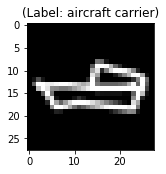

In [25]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
#curr_lbl = y_trn[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(LABELS[int(10/5000)]) + ")")



In [26]:
print(np.max(train_data))

255


In [27]:
train_data = train_data / np.max(train_data)

In [28]:
print(np.max(train_data))

1.0


In [29]:

train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

MemoryError: 

In [ ]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 345

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [65]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

NameError: name 'input_img' is not defined

In [ ]:
autoencoder.summary()

In [63]:
callback = [EarlyStopping(patience=1),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder1log.csv'),
                ModelCheckpoint('autoencoder1.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [64]:
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,validation_data=(valid_X, valid_ground),
                                   callbacks=callback)

NameError: name 'autoencoder' is not defined

ValueError: x and y must have same first dimension, but have shapes (200,) and (10,)

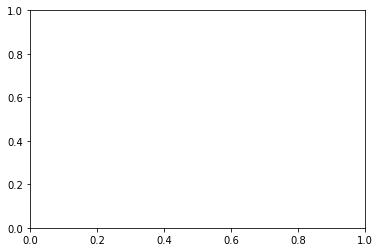

In [53]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [50]:
autoencoder.save_weights('autoencoder.h5')

In [16]:
train_labels=[int(i/5000) for i in range(0,1725000) ]
print(len(train_labels))
train_Y_one_hot = to_categorical(train_labels)


# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

1725000
Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [20]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1380000, 28, 28, 1), (345000, 28, 28, 1), (1380000, 345), (345000, 345))

In [21]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [22]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [25]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

Instructions for updating:
Colocations handled automatically by placer.


In [32]:
autoencoder.load_weights('autoencoder.h5')

In [33]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [34]:
autoencoder.get_weights()[0][1]

array([[[-4.96307500e-02, -2.64959073e+00, -2.95178536e-02,
         -1.04676616e+00,  8.68936330e-02,  9.69107687e-01,
         -3.41910064e-01, -1.04533744e+00,  2.15702150e-02,
          9.40196663e-02, -1.34976879e-01,  2.96876907e-01,
          5.84321916e-01, -5.39822757e-01, -4.51260544e-02,
          5.94212353e-01, -1.09639955e+00,  5.36705196e-01,
          1.41507089e-02, -1.67508766e-01,  7.95525908e-01,
          3.53343487e-01, -9.92079079e-02, -8.06467533e-02,
         -1.32826716e-02,  2.07283989e-01, -5.90708060e-03,
          1.21571738e-02,  6.92274034e-01,  2.36996189e-01,
          3.68026793e-01,  1.28752083e-01]],

       [[-9.99432206e-01, -3.61994833e-01,  6.22246452e-02,
         -3.17913115e-01, -1.73977047e-01,  1.88833103e-01,
          2.58020163e-01, -3.44199419e-01, -9.90749747e-02,
          2.56630957e-01,  6.25503361e-01,  5.67679882e-01,
         -7.68977642e-01, -1.34592497e+00,  3.72137517e-01,
          1.64162561e-01,  6.66346550e-02, -7.01439083

In [35]:
full_model.get_weights()[0][1]

array([[[-4.96307500e-02, -2.64959073e+00, -2.95178536e-02,
         -1.04676616e+00,  8.68936330e-02,  9.69107687e-01,
         -3.41910064e-01, -1.04533744e+00,  2.15702150e-02,
          9.40196663e-02, -1.34976879e-01,  2.96876907e-01,
          5.84321916e-01, -5.39822757e-01, -4.51260544e-02,
          5.94212353e-01, -1.09639955e+00,  5.36705196e-01,
          1.41507089e-02, -1.67508766e-01,  7.95525908e-01,
          3.53343487e-01, -9.92079079e-02, -8.06467533e-02,
         -1.32826716e-02,  2.07283989e-01, -5.90708060e-03,
          1.21571738e-02,  6.92274034e-01,  2.36996189e-01,
          3.68026793e-01,  1.28752083e-01]],

       [[-9.99432206e-01, -3.61994833e-01,  6.22246452e-02,
         -3.17913115e-01, -1.73977047e-01,  1.88833103e-01,
          2.58020163e-01, -3.44199419e-01, -9.90749747e-02,
          2.56630957e-01,  6.25503361e-01,  5.67679882e-01,
         -7.68977642e-01, -1.34592497e+00,  3.72137517e-01,
          1.64162561e-01,  6.66346550e-02, -7.01439083

In [36]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [37]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [38]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [40]:
callback = [EarlyStopping(patience=1),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder2log.csv'),
                ModelCheckpoint('autoencoder2.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [41]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label),
                               callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 1380000 samples, validate on 345000 samples
Epoch 1/10
1380000/1380000 [==============================] - 134s 97us/step - loss: 5.3991 - acc: 0.0124 - val_loss: 5.2028 - val_acc: 0.0190
Epoch 2/10
1380000/1380000 [==============================] - 129s 93us/step - loss: 5.1606 - acc: 0.0194 - val_loss: 5.1362 - val_acc: 0.0177
Epoch 3/10
1380000/1380000 [==============================] - 127s 92us/step - loss: 5.1024 - acc: 0.0213 - val_loss: 5.0848 - val_acc: 0.0230
Epoch 4/10
1380000/1380000 [==============================] - 128s 93us/step - loss: 5.0761 - acc: 0.0227 - val_loss: 5.0919 - val_acc: 0.0220


In [42]:
full_model.save_weights('autoencoder_classification.h5')

In [43]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [44]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [45]:
callback = [EarlyStopping(patience=5),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder3log.csv'),
                ModelCheckpoint('autoencoder3.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [46]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label),
                               callbacks=callback)

Train on 1380000 samples, validate on 345000 samples
Epoch 1/10
1380000/1380000 [==============================] - 333s 242us/step - loss: 5.0151 - acc: 0.0243 - val_loss: 4.8660 - val_acc: 0.0318
Epoch 2/10
1380000/1380000 [==============================] - 330s 239us/step - loss: 4.7931 - acc: 0.0346 - val_loss: 4.6701 - val_acc: 0.0457
Epoch 3/10
1380000/1380000 [==============================] - 330s 239us/step - loss: 4.6364 - acc: 0.0471 - val_loss: 4.5549 - val_acc: 0.0527
Epoch 4/10
1380000/1380000 [==============================] - 329s 238us/step - loss: 4.0822 - acc: 0.1295 - val_loss: 3.5284 - val_acc: 0.2300
Epoch 5/10
1380000/1380000 [==============================] - 327s 237us/step - loss: 2.9711 - acc: 0.3468 - val_loss: 2.5660 - val_acc: 0.4311
Epoch 6/10
1380000/1380000 [==============================] - 325s 236us/step - loss: 2.3635 - acc: 0.4756 - val_loss: 2.2100 - val_acc: 0.5110
Epoch 7/10
1380000/1380000 [==============================] - 330s 239us/step - los

In [47]:
full_model.save_weights('classification_complete.h5')

In [ ]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Testing

In [92]:
with open('test_final', 'rb') as ft:
    testlist = pickle.load(ft)

In [93]:
len(testlist)

345

In [94]:
def normalize(data):
    "Takes a list or a list of lists and returns its normalized form"

    return np.interp(data, [0, 255], [0, 1])

In [95]:
def make_labels(N1, N2):
    "make labels from 0 to N1, each repeated N2 times"
    labels = []
    for i in range(N1):
        labels += [i] * N2
    return labels

In [96]:
def set_limit(arrays, n):
    "Limit elements from each array up to n elements and return a single list"
    new = []
    for array in arrays:
        i = 0
        for item in array:
            if i == n:
                break
            new.append(item)
            i += 1
    return new


In [97]:
testlist = list(map(normalize, testlist))

In [98]:
len(testlist)

345

In [99]:

test_labels = make_labels(345, 10)


test_Y = keras.utils.to_categorical(test_labels, 345)




In [100]:
testlist = set_limit(testlist, 5000)

In [101]:
len(testlist)

3450

In [106]:
def visualize(array):
    "Visulaze a 2D array as an Image"
    array = np.reshape(array, (28,28))
    img = Image.fromarray(array)
    return img

In [105]:
predsTest = full_model.predict(np.array(testlist))
# print(predsTest)
score = 0
for i in range(len(predsTest)):
    #print(np.argmax(predsTest[i]))
    if np.argmax(predsTest[i]) == test_labels[i]:
        score += 1

print("Accuracy: ", ((score + 0.0) / len(predsTest)) * 100,"%")

Accuracy:  64.17391304347827 %
